# Single Particle Model (SPM): Fit initial/typical electrolyte concentration

## Model Equations

The SPM consists of two spherically symmetric diffusion equations: one within a representative negative particle ($\text{k}=\text{n}$) and one within a representative positive particle ($\text{k}=\text{p}$). In the centre of the particle the standard no-flux condition is imposed. Since the SPM assumes that all particles in an electrode behave in exactly the same way, the flux on the surface of a particle is simply the current $I$ divided by the thickness of the electrode $L_{\text{k}}$. The concentration of lithium in electrode $\text{k}$ is denoted $c_{\text{k}}$ and the current is denoted by $I$. All parameters in the model stated here are dimensionless and are given in terms of dimensional parameters at the end of this notebook. The model equations for the SPM are then: 
$$
\begin{align}
\mathcal{C}_{\text{k}} \frac{\partial c_{\text{s,k}}}{\partial t} &= -\frac{1}{r_{\text{k}}^2} \frac{\partial}{\partial r_{\text{k}}} \left(r_{\text{k}}^2 N_{\text{s,k}}\right), \\
N_{\text{s,k}} &= -D_{\text{s,k}}(c_{\text{s,k}}) \frac{\partial c_{\text{s,k}}}{\partial r_{\text{k}}}, \quad \text{k} \in \text{n, p}, 
\end{align}
$$
$$
N_{\text{s,k}}\big|_{r_{\text{k}}=0} = 0, \quad \text{k} \in \text{n, p}, \quad \ \ - \frac{a_{R, \text{k}}\gamma_{\text{k}}}{\mathcal{C}_{\text{k}}} N_{\text{s,k}}\big|_{r_{\text{k}}=1} = 
\begin{cases}
		  \frac{I}{L_{\text{n}}}, \quad &\text{k}=\text{n}, \\ 
		  -\frac{I}{L_{\text{p}}}, \quad &\text{k}=\text{p}, 
\end{cases} \\
c_{\text{s,k}}(r_{\text{k}},0) = c_{\text{s,k,0}}, \quad \text{k} \in \text{n, p},$$
where $D_{\text{s,k}}$ is the diffusion coefficient in the solid, $N_{\text{s,k}}$ denotes the flux of lithium ions in the solid particle within the region $\text{k}$, and $r_{\text{k}} \in[0,1]$ is the radial coordinate of the particle in electrode $\text{k}$. 

### Voltage Expression
The terminal voltage is obtained from the expression: 
$$
V = U_{\text{p}}(c_{\text{p}})\big|_{r_{\text{p}}=1} - U_{\text{n}}(c_{\text{n}})\big|_{r_{\text{n}}=1} -2\sinh^{-1}\left(\frac{I}{j_{\text{0,p}} L_{\text{p}}}\right) - 2\sinh^{-1}\left(\frac{I}{j_{\text{0,n}} L_{\text{n}}}\right)
$$
with the exchange current densities given by
$$j_{\text{0,k}} =  \frac{\gamma_{\text{k}}}{\mathcal{C}_{\text{r,k}}}(c_{\text{k}})^{1/2}(1-c_{\text{k}})^{1/2}  $$

More details can be found in [[3]](#References).

## Example solving SPM using PyBaMM

Below we show how to solve the Single Particle Model, using the default geometry, mesh, parameters, discretisation and solver provided with PyBaMM. In this notebook we explicitly handle all the stages of setting up, processing and solving the model in order to explain them in detail. However, it is often simpler in practice to use the `Simulation` class, which handles many of the stages automatically, as shown [here](../simulation-class.ipynb).

First we need to import `pybamm`, and then change our working directory to the root of the pybamm folder. 

In [26]:
# %pip install DFO-LS -q
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
import dfols
from scipy.optimize import curve_fit

# from multiprocessing import Process, Pool

# from scipy.optimize import minimize
print(pybamm.__path__[0])
%matplotlib widget


c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


# Load pulse testing data

In [27]:
data = pd.read_csv(
    "./fast_discharge/2C_pulse_test_data_DCR_Cell_43.csv"#, comment="#", header=None
)
df_labels = ['t', 'V', 'AhT','Temp', 'Q', 'I']
data.set_axis(df_labels, axis=1, inplace=True)
data.AhT = -data.AhT/1000 
data['I_C'] = data.I/4.6
data['SOC'] = 1-data.AhT/4.2
data

,t,V,AhT,Temp,Q,I,I_C,SOC
0,0.000000,4.196902,-0.000000,22.914967,2292.862303,-0.000000,-0.000000,1.000000
1,10.000000,4.196824,-0.000000,23.048939,2292.862303,-0.000000,-0.000000,1.000000
2,20.000001,4.196784,-0.000000,22.993774,2292.862303,-0.000000,-0.000000,1.000000
3,30.000001,4.196745,-0.000000,22.993774,2292.862303,-0.000000,-0.000000,1.000000
4,40.000002,4.196627,-0.000000,22.788877,2292.862303,-0.000000,-0.000000,1.000000
...,...,...,...,...,...,...,...,...
4096,5602.088266,3.204265,4.073620,24.183754,4072.425625,8.995825,1.955614,0.030090
4097,5612.088267,3.162594,4.098613,24.231037,4097.418306,8.995825,1.955614,0.024140
4098,5622.088267,3.106940,4.123605,24.412292,4122.410880,8.996416,1.955743,0.018189
4099,5632.088268,3.029937,4.148598,24.459576,4147.403525,8.997204,1.955914,0.012239


# Find and plot indices of pulse rest 

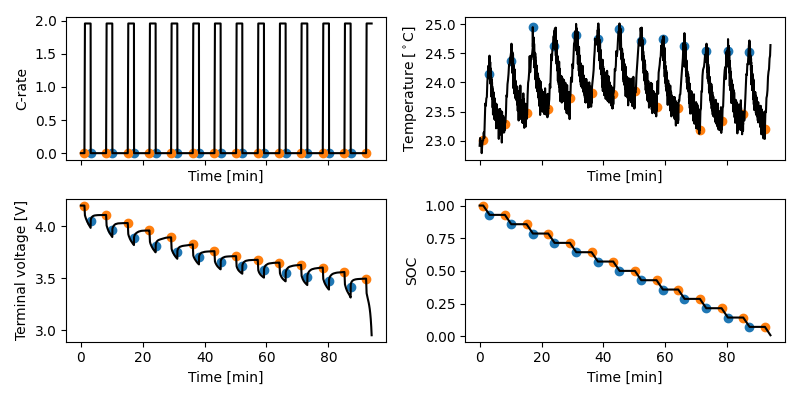

In [28]:
# find pulse indices
I = data.I
pulse_current = max(I)
i1 = np.where((np.diff(I)<-0.1))[0]
i1 = i1+1
# i1 = np.append(i1,len(I)-1)
i2 = np.where((np.diff(I)>0.1) & (I[1:]>pulse_current-0.1)& (I[1:]<pulse_current+0.1))[0]
# i2 = np.insert(i2,0,1)
# plot
fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
ax = ax.flatten()
linestyles = ['-','--',':','.-']*2

t = data.t/60
xlabel = "Time [min]"
data_color = 'k'
ax[0].plot(t,data.I_C, label='Data', color = data_color)
ax[0].scatter(t[i1], data.I_C[i1])
ax[0].scatter(t[i2], data.I_C[i2])
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel('C-rate')

ax[2].plot(t, data.V,color = data_color)
ax[2].scatter(t[i1], data.V[i1])
ax[2].scatter(t[i2], data.V[i2])
ax[2].set_xlabel(xlabel)
ax[2].set_ylabel('Terminal voltage [V]')

ax[1].plot(t, data.Temp, color = data_color)
ax[1].scatter(t[i1], data.Temp[i1])
ax[1].scatter(t[i2], data.Temp[i2])
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel('Temperature [$^\circ$C]')

ax[3].plot(t, data.SOC, color = data_color)
ax[3].scatter(t[i1], data.SOC[i1])
ax[3].scatter(t[i2], data.SOC[i2])
ax[3].set_xlabel(xlabel)
ax[3].set_ylabel('SOC')

plt.tight_layout()
plt.show()


In [29]:
def plot_pulse(data, solutions, labels = []):
    fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
    ax = ax.flatten()
    linestyles = ['-','--',':','.-']*2

    t = data.t/60
    xlabel = "Time [min]"
    data_color = 'k'
    ax[0].plot(t,data.I_C, label='Data', color = data_color)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate')


    ax[2].plot(t, data.V,color = data_color)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('Terminal voltage [V]')

    ax[1].plot(t, data.Temp, color = data_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Temperature [$^\circ$C]')

    ax[3].plot(t, data.SOC, color = data_color)
    ax[3].set_xlabel(xlabel)
    ax[3].set_ylabel('SOC')

    sim_colors = ['r','g','b','m']*2
    for i,solution in enumerate(solutions):
        t = solution["Time [s]"].entries
        x = solution["x [m]"].entries[:, 0]
        I = solution['C-rate']
        V = solution['Terminal voltage [V]']
        T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
        soc = solution['R-averaged negative particle concentration']

        x_plot = t/60
        ax[0].plot(x_plot, I(t), linestyle=':',color = sim_colors[i])
        ax[2].plot(x_plot, V(t), linestyle=':',color = sim_colors[i])
        ax[1].plot(x_plot, T,linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)
        ax[3].plot(x_plot, soc(t=t, x=x[-1]),linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)


    plt.tight_layout()
    plt.show()


# Set up nominal model

2023-05-18 11:07:39.441 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Run pulse (A) until 3.0 V'. The returned solution only contains up to step 1 of cycle 1. 
2023-05-18 11:07:47.515 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-18 11:08:08.439 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


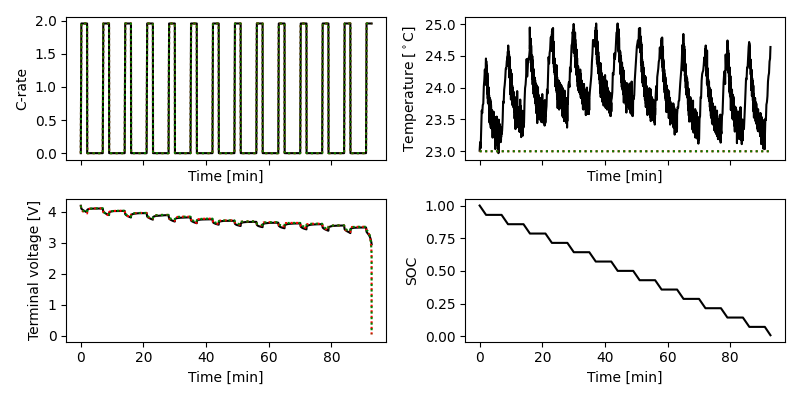

In [32]:
# set up pulse data
pulse = data[i2[0]::].copy()
pulse.t = pulse.t-pulse.t.iloc[0]

# define parameters for simulation
SOC_0 = pulse.SOC.iloc[0]
pulse_current = pulse[['t','I']].to_numpy()

# set up and solve model
# solutions = []
options = {
    # "thermal": "x-lumped",
}
model = pybamm.lithium_ion.SPMe(options = options)
param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
param.update({
    "Lower voltage cut-off [V]": 0,
    "Nominal cell capacity [A.h]": 4.6,
    "Typical current [A]":4.6,
    "Negative tab width [m]":2.5e-2,
    "Positive tab width [m]":2.5e-2,
    "Negative electrode thickness [m]":62E-06*4.2/5,
    "Positive electrode thickness [m]":67E-06*4.2/5,
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Edge heat transfer coefficient [W.m-2.K-1]":5,
    "Total heat transfer coefficient [W.m-2.K-1]":5,
    "Negative electrode diffusivity [m2.s-1]": 8.0E-14, 
    "Positive electrode diffusivity [m2.s-1]": 8.0E-15, 
    "Ambient temperature [K]": 23+273.15,
    "Initial temperature [K]": 23 + 273.15,

    "Initial concentration in electrolyte [mol.m-3]":1200, 
    "Typical electrolyte concentration [mol.m-3]": 1200,

}, check_already_exists = False)
experiment = pybamm.Experiment(
        [
        "Run pulse (A) until 3.0 V"
        ],
        drive_cycles={
            'pulse': pulse_current
        }
    )
sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
solution = sim.solve( initial_soc=SOC_0)
solutions.append(solution)

# plot simulation results 
plot_pulse(pulse,solutions)

# Set up loss function for parameterization

In [ ]:
# # run simulation with input k to scale D and output error metric
# # Input and output are np.array
def simulate_pulse(k:np.ndarray): 
    c_e_0 = 1000
    param.update({
        "Initial concentration in electrolyte [mol.m-3]":c_e_0*k[0], 
        "Typical electrolyte concentration [mol.m-3]": c_e_0*k[0],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    return np.array([rmse_V])
    

# test function
print(simulate_pulse(np.array([1])))


2023-05-18 10:47:49.634 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Run pulse (A) until 3.0 V'. The returned solution only contains up to step 1 of cycle 1. 


[0.02314185]


# Fit single pulse and save 

2023-05-18 11:44:18.287 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Run pulse (A) until 3.0 V'. The returned solution only contains up to step 1 of cycle 1. 
2023-05-18 11:44:34.412 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Run pulse (A) until 3.0 V'. The returned solution only contains up to step 1 of cycle 1. 
2023-05-18 11:44:53.077 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Run pulse (A) until 3.0 V'. The returned solution only contains up to step 1 of cycle 1. 
2023-05-18 11:45:15.781 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Run pulse (A) until 3.0 V'. The returned solution only contains up to step 1 of cycle 1. 
2023-05-18 11:45:34.418 - [W

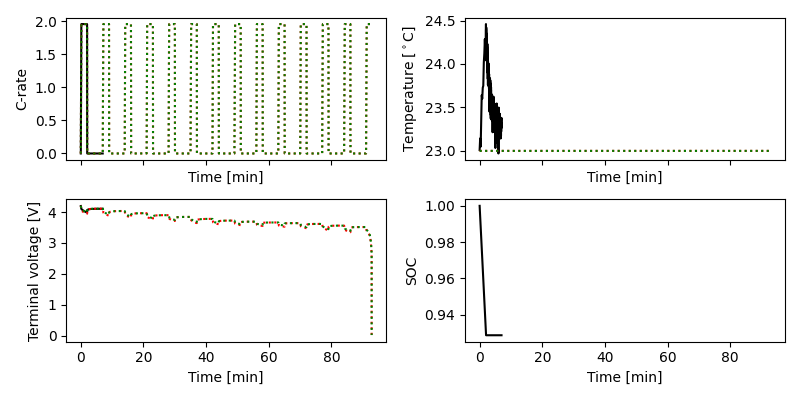

In [33]:
c_e_0 = 1000
lb = np.array([1])
ub = np.array([10])
# define pulse data
pulse = data[i2[0]:i2[1]].copy()
pulse.t = pulse.t-pulse.t.iloc[0]

# define sim parameters
SOC_0 = pulse.SOC.iloc[0]
pulse_current = pulse[['t','I']].to_numpy()
    
# fit k for k*c_e_0
k0 = np.array([1])   
k = dfols.solve(simulate_pulse, k0, bounds = (lb,ub), rhoend=1e-3)

solutions = []
# nominal
param.update({
    "Initial concentration in electrolyte [mol.m-3]":c_e_0, 
    "Typical electrolyte concentration [mol.m-3]": c_e_0,
    })
sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
solution0 = sim0.solve(initial_soc=SOC_0)
solutions.append(solution0)

# fitted
param.update({
    "Initial concentration in electrolyte [mol.m-3]":c_e_0*k.x[0], 
    "Typical electrolyte concentration [mol.m-3]": c_e_0*k.x[0],
    })
    
sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
solution = sim.solve(initial_soc=SOC_0)
solutions.append(solution)

# plot with 
plot_pulse(pulse,solutions)

In [34]:
k.x[0]

3.3000000000000007